In [6]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For full reproducibility (slightly slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


## 1. TCP with MSE Loss

In [7]:
import numpy as np
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
#show the keys in the file
print(data.files)
embeddings = data['test_embeddings']
print("shape of embeddings:" , embeddings.shape)
probs= data['probs']
print("shape of probs:", probs.shape)
y_labels = data['y_labels']
print("Shape of labels:", y_labels.shape)
y_true = data['y_train']
print("Shape of y_true:", y_true.shape)
print("Label names:", np.unique(data['y_labels']))


['test_embeddings', 'y_train', 'y_labels', 'audio_num', 'probs', 'audio_names']
shape of embeddings: (5702, 64)
shape of probs: (5702, 12)
Shape of labels: (5702,)
Shape of y_true: (5702, 12)
Label names: ['Bhairavi' 'Bihag' 'Des' 'Jog' 'Kedar' 'Khamaj' 'Malkauns' 'Maru_bihaag'
 'Nayaki_kanada' 'Shuddha_kalyan' 'Sohni' 'Yaman']


In [8]:
#Predicted class
y_hat = np.argmax(probs, axis=1)
print("predicted class :", y_hat)
#Prob of predicted class
p_y_hat = np.max(probs, axis=1)
print("predicted probabilities :", p_y_hat)

#True class one hot matrix
y_star= y_true
print("true class :", y_star)
#Prob of true class
p_y_star = np.sum(probs * y_star, axis=1)
print("true class probabilities :", p_y_star)

#True class labels
y_true_class = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
print("true class labels :", y_true_class)


predicted class : [ 1 11  9 ... 11  9  1]
predicted probabilities : [0.544058   0.97347754 0.7518662  ... 0.96628433 0.9899086  0.9475812 ]
true class : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]
true class probabilities : [0.4308202  0.97347754 0.23816009 ... 0.96628433 0.98990858 0.94758117]
true class labels : [ 8 11 11 ... 11  9  1]


In [9]:
#Computing ECE
def compute_ECE(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.sum(in_bin) / total_samples

        if np.sum(in_bin) > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin)

    return ece


In [10]:
#Predicted class
y_hat = np.argmax(probs, axis=1)
print("predicted class :", y_hat.shape)
#Prob of predicted class
p_y_hat = np.max(probs, axis=1)
print("predicted probabilities :", p_y_hat.shape)

#True class one hot matrix
y_star= y_true
print("true class :", y_star)
#Prob of true class
p_y_star = np.sum(probs * y_star, axis=1)
print("true class probabilities :", p_y_star.shape)

#True class labels
y_true_class = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
print("true class labels :", y_true_class.shape)


predicted class : (5702,)
predicted probabilities : (5702,)
true class : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]
true class probabilities : (5702,)
true class labels : (5702,)


### Using TCPr

In [11]:
def compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha):
    indicator = (y_true_class != y_hat).astype(float)
    numerator = p_y_star
    denominator = p_y_hat + (indicator * (p_y_star + alpha))
    tcp_star_targets = numerator / denominator
    return tcp_star_targets

tcp_star_targets = compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha=0.3)
print("tcp_star_targets shape:", tcp_star_targets)

tcp_star_targets shape: [0.33793047 1.         0.18461646 ... 1.         1.         1.        ]


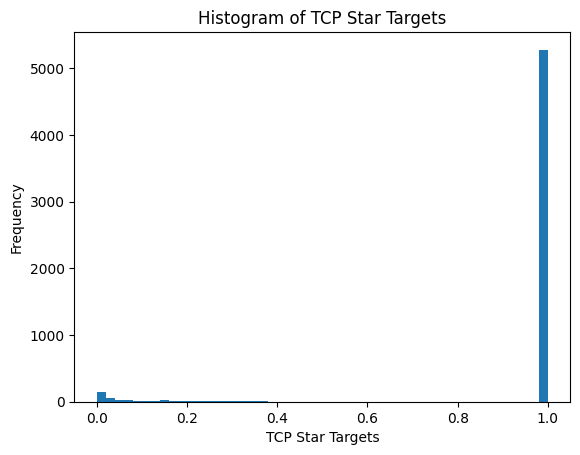

In [12]:
#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(tcp_star_targets, bins=50)
plt.xlabel('TCP Star Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Star Targets')
plt.show()

In [13]:
# Upsampling the errors to create a balanced batch 

# Select indices
correct_idx = np.where(y_hat == y_true_class)[0]
error_idx = np.where(y_hat != y_true_class)[0]

# You can duplicate errors to balance them
n_errors = len(error_idx)
n_correct = len(correct_idx)
upsample_errors = np.random.choice(error_idx, size=n_correct, replace=True)

balanced_idx = np.concatenate([correct_idx, upsample_errors])
np.random.shuffle(balanced_idx)

X_balanced = embeddings[balanced_idx]
y_balanced = tcp_star_targets[balanced_idx]
print("Balanced embeddings shape:", X_balanced.shape)
print("Balanced TCP Star Targets shape:", y_balanced.shape)

Balanced embeddings shape: (10552, 64)
Balanced TCP Star Targets shape: (10552,)


In [16]:
n_errors


426

In [ ]:
n_errors = len(error_idx)
print("Number of correct predictions:", len(correct_idx))
print("Number of errors:", n_errors)

Number of correct predictions: 5276
Number of errors: 426


In [ ]:
X=X_balanced
y=y_balanced

In [ ]:
from sklearn.model_selection import train_test_split

# 80% for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
import torch.nn as nn

class ConfidenceNet(nn.Module):
    def __init__(self, input_dim):
        super(ConfidenceNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim import AdamW

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset= TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

input_dim = X_train.shape[1]
output_dim = 1
model = ConfidenceNet(input_dim)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.MSELoss()

# Training the model
for epoch in range(60):
    model.train()
    train_losses=[]
    for xb, yb in train_loader:
        pred=model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1:02d} | Train Loss: {sum(train_losses)/len(train_losses):.6f} | "
          f"Val Loss: {sum(val_losses)/len(val_losses):.6f}")

Epoch 01 | Train Loss: 0.135740 | Val Loss: 0.117792
Epoch 02 | Train Loss: 0.112079 | Val Loss: 0.110529
Epoch 03 | Train Loss: 0.102220 | Val Loss: 0.103487
Epoch 04 | Train Loss: 0.097548 | Val Loss: 0.093767
Epoch 05 | Train Loss: 0.089997 | Val Loss: 0.086024
Epoch 06 | Train Loss: 0.085726 | Val Loss: 0.087184
Epoch 07 | Train Loss: 0.079362 | Val Loss: 0.077662
Epoch 08 | Train Loss: 0.075673 | Val Loss: 0.084761
Epoch 09 | Train Loss: 0.072958 | Val Loss: 0.073931
Epoch 10 | Train Loss: 0.066770 | Val Loss: 0.071932
Epoch 11 | Train Loss: 0.063476 | Val Loss: 0.070540
Epoch 12 | Train Loss: 0.058992 | Val Loss: 0.072209
Epoch 13 | Train Loss: 0.060129 | Val Loss: 0.077239
Epoch 14 | Train Loss: 0.054673 | Val Loss: 0.055773
Epoch 15 | Train Loss: 0.051450 | Val Loss: 0.068324
Epoch 16 | Train Loss: 0.049812 | Val Loss: 0.065520
Epoch 17 | Train Loss: 0.047973 | Val Loss: 0.060243
Epoch 18 | Train Loss: 0.044149 | Val Loss: 0.055861
Epoch 19 | Train Loss: 0.042453 | Val Loss: 0.

In [ ]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(embeddings, dtype=torch.float32)
    confidence_scores_tcpr = model(X_test_tensor).numpy()  # shape: (5702,)
print("Confidence scores shape:", confidence_scores_tcpr.shape) #score from the final sigmoid layer

Confidence scores shape: (5702,)


In [ ]:
#min and max values of confidence scores
print("Min value in confidence scores:", np.min(confidence_scores_tcpr))
print("Max value in confidence scores:", np.max(confidence_scores_tcpr))

Min value in confidence scores: 0.00038200538
Max value in confidence scores: 1.0


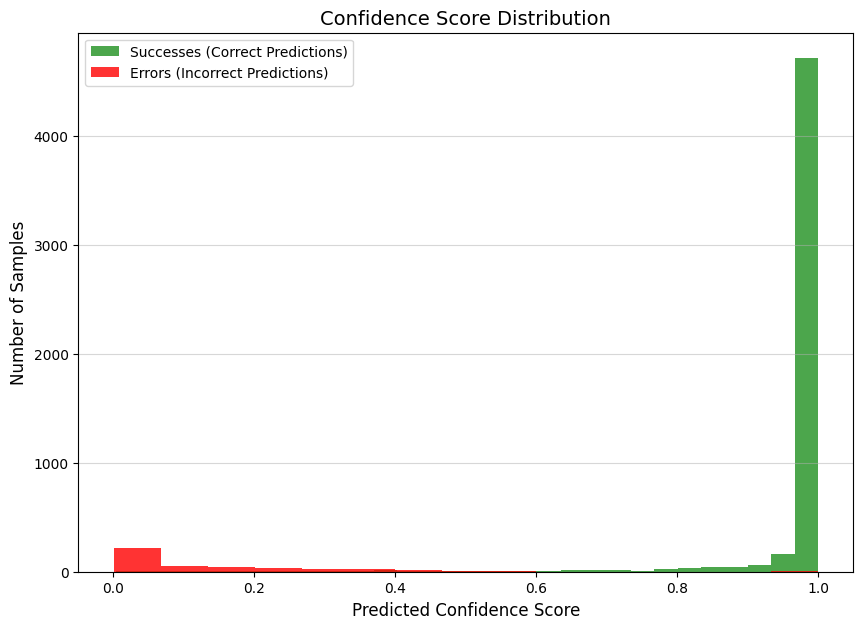

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_labels_int = label_encoder.fit_transform(y_labels)
is_correct = (y_hat == y_true_class)
success_confidences = confidence_scores_tcpr[is_correct]
error_confidences = confidence_scores_tcpr[~is_correct]

plt.figure(figsize=(10, 7))
# bins = np.linspace(0, 1, 50)
# plt.hist(success_confidences, bins=bins, alpha=0.7, label='Success', color='green')
# plt.hist(error_confidences, bins=bins, alpha=0.7, label='Error', color='red')

plt.hist(success_confidences, bins=30, alpha=0.7, label='Successes (Correct Predictions)', color='green')
plt.hist(error_confidences, bins=15, alpha=0.8, label='Errors (Incorrect Predictions)', color='red')
plt.xlabel('Predicted Confidence Score', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Confidence Score Distribution', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()



In [ ]:
ece_confidnet= compute_ECE(confidence_scores_tcpr, y_hat, y_labels_int)
print(f"ECE for Your Learned Confidence Model (TCP*): {ece_confidnet:.4f}")

ECE for Your Learned Confidence Model (TCP*): 418.3150


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# BASELINE performance on the ENTIRE dataset
print("--- Baseline Performance (All 5702 Samples) ---")
print(classification_report(y_labels_int, y_hat, target_names=label_encoder.classes_))
print(f"Overall Baseline Accuracy: {accuracy_score(y_labels_int, y_hat):.4f}\n")

#Choose a confidence threshold
confidence_threshold = 0.3

high_confidence_mask = (confidence_scores_tcpr >= confidence_threshold)

filtered_y_true = y_labels_int[high_confidence_mask]
filtered_y_pred = y_hat[high_confidence_mask]
print(f"--- Performance on High-Confidence Samples (Threshold = {confidence_threshold}) ---")
num_kept = len(filtered_y_true)
num_total = len(y_labels_int)
print(f"Kept {num_kept} of {num_total} samples ({num_kept/num_total:.2%}) for evaluation.\n")

if num_kept > 0:
    print(classification_report(filtered_y_true, filtered_y_pred, target_names=label_encoder.classes_))
    print(f"Accuracy on Filtered Set: {accuracy_score(filtered_y_true, filtered_y_pred):.4f}")
else:
    print("No samples remained after filtering with this threshold.")

--- Baseline Performance (All 5702 Samples) ---
                precision    recall  f1-score   support

      Bhairavi       0.91      0.96      0.93       220
         Bihag       0.89      0.95      0.92       655
           Des       0.83      0.78      0.80       150
           Jog       0.97      0.97      0.97       685
         Kedar       0.91      0.93      0.92       389
        Khamaj       0.75      0.79      0.77       198
      Malkauns       0.98      0.97      0.98       560
   Maru_bihaag       0.90      0.84      0.87       633
 Nayaki_kanada       0.98      0.97      0.97       499
Shuddha_kalyan       0.96      0.92      0.94       721
         Sohni       0.93      0.94      0.94       331
         Yaman       0.90      0.92      0.91       661

      accuracy                           0.93      5702
     macro avg       0.91      0.91      0.91      5702
  weighted avg       0.93      0.93      0.93      5702

Overall Baseline Accuracy: 0.9253

--- Performance on

### Using MCP

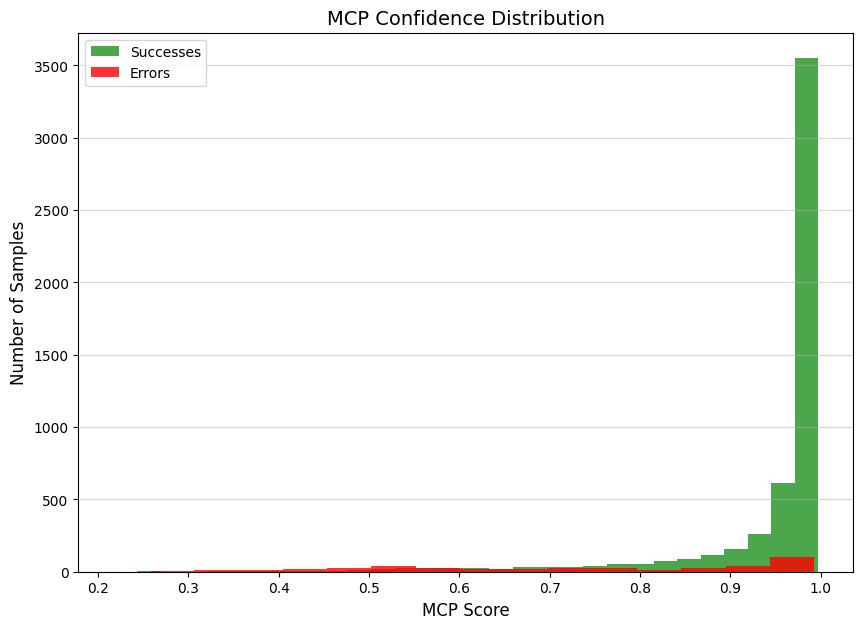

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

mcp_scores = np.max(probs, axis=1)
is_correct = (y_hat == y_labels_int)
mcp_success_confidences = mcp_scores[is_correct]
mcp_error_confidences = mcp_scores[~is_correct]

plt.figure(figsize=(10, 7))
plt.hist(mcp_success_confidences, bins=30, alpha=0.7, label='Successes', color='green')
plt.hist(mcp_error_confidences, bins=15, alpha=0.8, label='Errors', color='red')
plt.title('MCP Confidence Distribution', fontsize=14)
plt.xlabel('MCP Score', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


In [ ]:
ece_mcp = compute_ECE(mcp_scores, y_hat, y_labels_int)
print(f"ECE for MCP Confidence Baseline: {ece_mcp:.4f}")    

ECE for MCP Confidence Baseline: 342.9302


### TCP

In [ ]:
tcp_targets= p_y_star / p_y_hat
print(tcp_targets.shape)

(5702,)


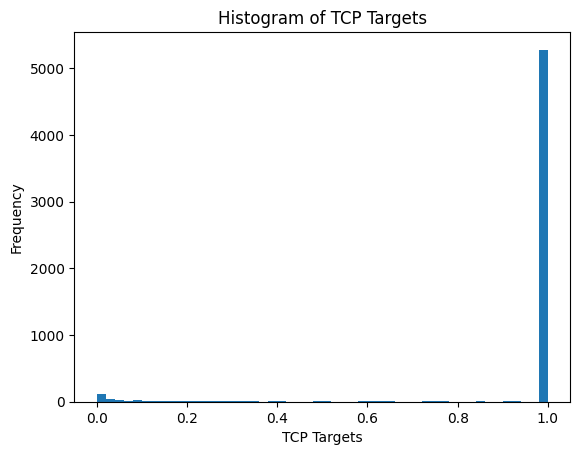

In [ ]:
#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(tcp_targets, bins=50)
plt.xlabel('TCP Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Targets')
plt.show()

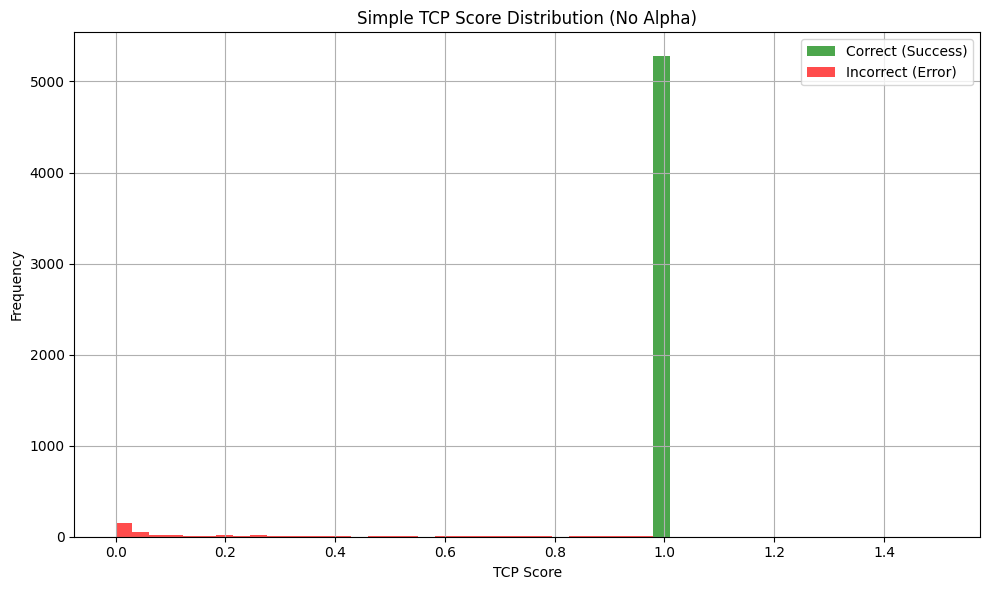

In [ ]:
# --- Plot histogram of TCP scores ---
success_tcp = tcp_targets[is_correct]
error_tcp = tcp_targets[~is_correct]

plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1.5, 50)
plt.hist(success_tcp, bins=bins, alpha=0.7, label='Correct (Success)', color='green')
plt.hist(error_tcp, bins=bins, alpha=0.7, label='Incorrect (Error)', color='red')
plt.xlabel("TCP Score")
plt.ylabel("Frequency")
plt.title("Simple TCP Score Distribution (No Alpha)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
ece_tcp = compute_ECE(tcp_targets, y_hat, y_labels_int)
print(f"ECE for Simple TCP: {ece_tcp:.4f}")

ECE for Simple TCP: 2996.7087


# 2. TCP with MSE + FDS + LDS

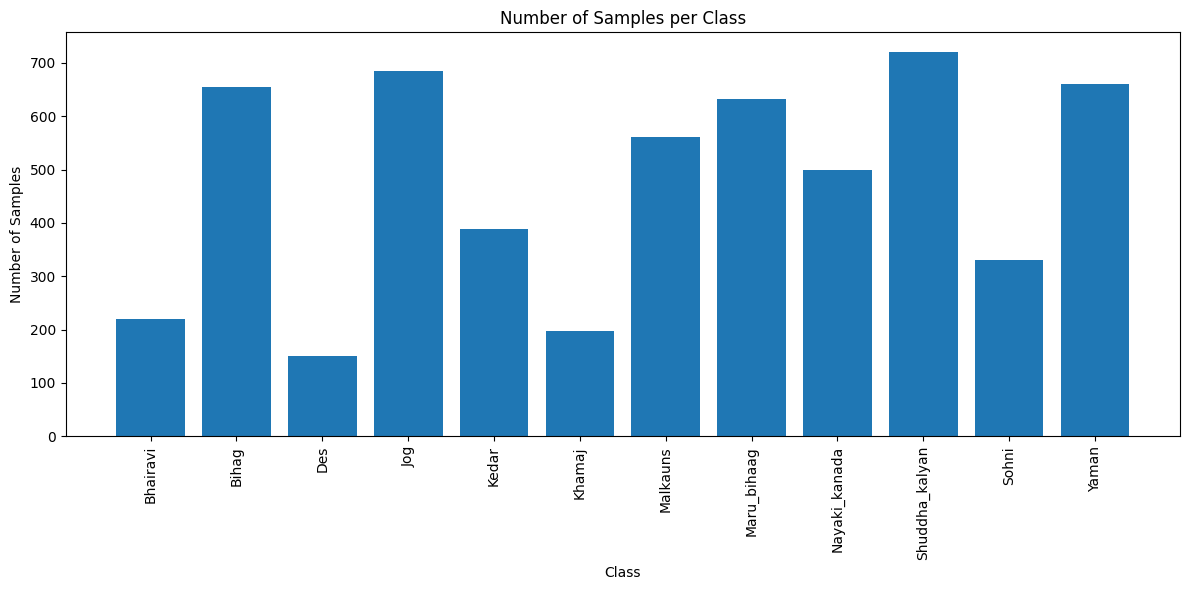

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Count samples per class
unique_classes, class_counts = np.unique(y_labels, return_counts=True)

plt.figure(figsize=(12, 6))
plt.bar(unique_classes, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
y_balanced.shape #this is my continuous target for the confidnet

(10552,)

In [ ]:
from scipy.stats import gaussian_kde # For Kernel Density Estimation
kde = gaussian_kde(y_train, bw_method=0.01) # 'silverman' is a common default

# For each y_train sample, get its estimated density
sample_densities = kde.evaluate(y_train)

# Ensure no zero densities (or very tiny) to avoid division by zero
sample_densities = np.maximum(sample_densities, 1e-6)
weights = 1.0 / sample_densities

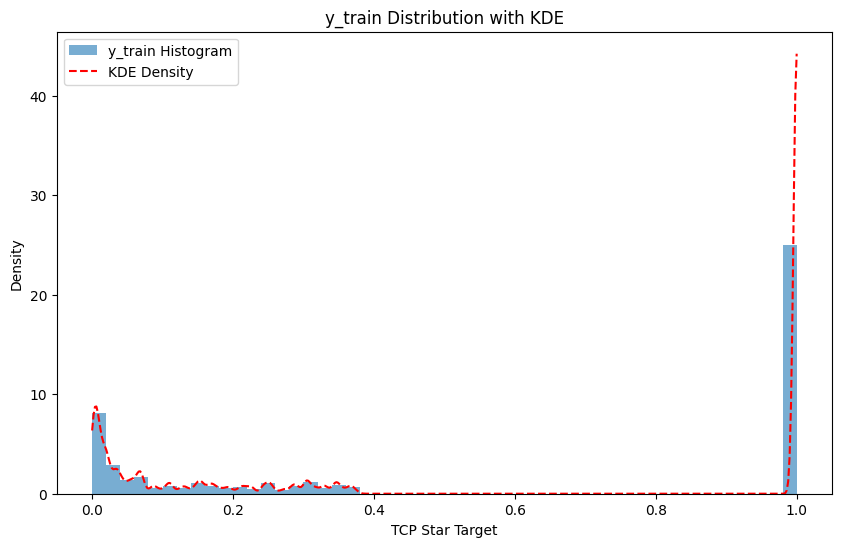

In [ ]:
# After calculating kde = gaussian_kde(y_train, bw_method='silverman')
# Create a range of x values to evaluate the KDE
x_plot = np.linspace(0, 1, 500)
density_values = kde.evaluate(x_plot)

plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=50, density=True, alpha=0.6, label='y_train Histogram')
plt.plot(x_plot, density_values, color='red', linestyle='--', label='KDE Density')
plt.title('y_train Distribution with KDE')
plt.xlabel('TCP Star Target')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
weights = weights / np.mean(weights)
print(f"Min weight: {np.min(weights):.4f}, Max weight: {np.max(weights):.4f}, Mean weight: {np.mean(weights):.4f}")


Min weight: 0.0610, Max weight: 8.3107, Mean weight: 1.0000


In [ ]:
weights_tensor = torch.tensor(weights, dtype=torch.float32)


In [ ]:
model_2= ConfidenceNet(input_dim)

In [ ]:
train_dataset_wt = TensorDataset(X_train_tensor, y_train_tensor, weights_tensor) # Include weights
train_loader_wt = DataLoader(train_dataset_wt, batch_size=64, shuffle=True)


In [ ]:
for epoch in range(60):
    model_2.train()
    train_losses = []
    for xb, yb, wb in train_loader_wt: # Unpack weights from loader
        pred = model_2(xb)
        # Calculate weighted MSE loss
        loss = torch.mean(wb * (pred - yb)**2) # Weighted Mean Squared Error
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
    model_2.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model_2(xb)
            loss = nn.MSELoss()(pred, yb) # Standard MSE for validation
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1:02d} | Train Loss: {sum(train_losses)/len(train_losses):.6f} | "
          f"Val Loss: {sum(val_losses)/len(val_losses):.6f}")


Epoch 01 | Train Loss: 0.121425 | Val Loss: 0.209679
Epoch 02 | Train Loss: 0.121441 | Val Loss: 0.209491
Epoch 03 | Train Loss: 0.121400 | Val Loss: 0.209711
Epoch 04 | Train Loss: 0.121222 | Val Loss: 0.209565
Epoch 05 | Train Loss: 0.121283 | Val Loss: 0.209656
Epoch 06 | Train Loss: 0.121401 | Val Loss: 0.209403
Epoch 07 | Train Loss: 0.121263 | Val Loss: 0.209854
Epoch 08 | Train Loss: 0.121464 | Val Loss: 0.210036
Epoch 09 | Train Loss: 0.121316 | Val Loss: 0.209756
Epoch 10 | Train Loss: 0.121232 | Val Loss: 0.209744
Epoch 11 | Train Loss: 0.121295 | Val Loss: 0.209752
Epoch 12 | Train Loss: 0.121369 | Val Loss: 0.209962
Epoch 13 | Train Loss: 0.121340 | Val Loss: 0.209406
Epoch 14 | Train Loss: 0.121349 | Val Loss: 0.209647
Epoch 15 | Train Loss: 0.121374 | Val Loss: 0.210004
Epoch 16 | Train Loss: 0.121361 | Val Loss: 0.209463
Epoch 17 | Train Loss: 0.121359 | Val Loss: 0.209902
Epoch 18 | Train Loss: 0.121392 | Val Loss: 0.209696
Epoch 19 | Train Loss: 0.121366 | Val Loss: 0.

In [ ]:
model_2.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(embeddings, dtype=torch.float32) # Using original `embeddings` for final confidence prediction
    confidence_scores_2 = model_2(X_test_tensor).numpy()
print("Confidence scores shape:", confidence_scores_2.shape)


Confidence scores shape: (5702,)


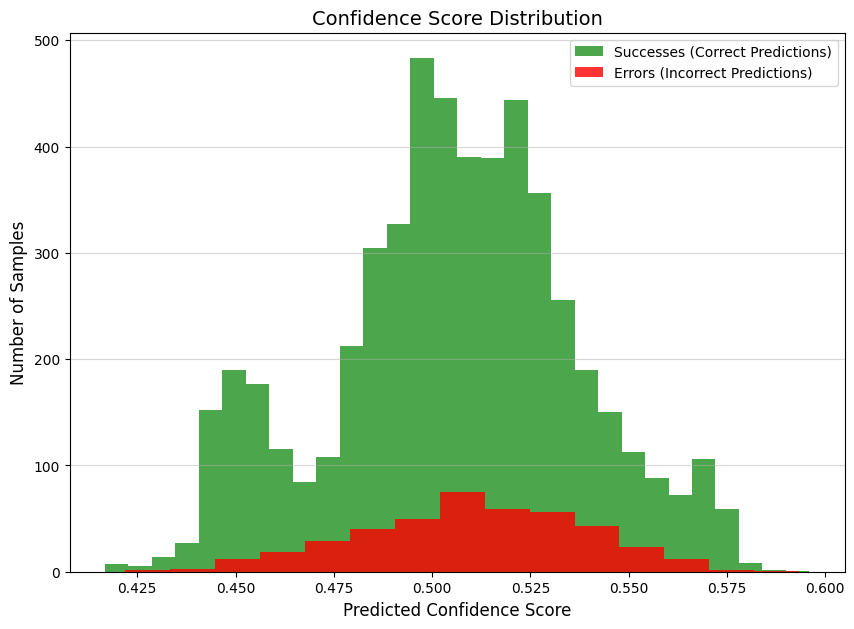

In [ ]:
label_encoder = LabelEncoder()
y_labels_int = label_encoder.fit_transform(y_labels) # Assuming y_labels is from the test set for this plot
# You need y_true_class for the test set here, which corresponds to `embeddings`
# If `y_true_class` (derived from `y_true`) is from the full dataset that `embeddings` also represents, then it's fine.
# Otherwise, you need to load/derive true labels for the `embeddings` used here.
is_correct = (y_hat == y_true_class) # y_hat and y_true_class must correspond to `embeddings` and `probs`
success_confidences = confidence_scores_2[is_correct]
error_confidences = confidence_scores_2[~is_correct]

plt.figure(figsize=(10, 7))
plt.hist(success_confidences, bins=30, alpha=0.7, label='Successes (Correct Predictions)', color='green')
plt.hist(error_confidences, bins=15, alpha=0.8, label='Errors (Incorrect Predictions)', color='red')
plt.xlabel('Predicted Confidence Score', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Confidence Score Distribution', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
ece_confidnet= compute_ECE(confidence_scores_2, y_hat, y_labels_int)
print(f"ECE for Your Learned Confidence Model (TCP*): {ece_confidnet:.4f}")

ECE for Your Learned Confidence Model (TCP*): 6.3962


## Just using LDS


In [ ]:
# Preprocessing

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_lds_weights(y, num_bins=40, kernel_sigma=2.0):
    
    bins = np.linspace(0, 1, num_bins + 1)
    bin_ids = np.digitize(y, bins) - 1  # Bin index per sample
    bin_ids = np.clip(bin_ids, 0, num_bins - 1)

    counts = np.bincount(bin_ids, minlength=num_bins)

    def gaussian_kernel(dist, sigma):
        return np.exp(-0.5 * (dist / sigma) ** 0.5)

    smoothed_counts = np.zeros_like(counts, dtype=np.float32)
    for i in range(num_bins):
        distances = np.arange(num_bins) - i
        kernel = gaussian_kernel(distances, sigma=kernel_sigma)
        kernel /= kernel.sum()
        smoothed_counts[i] = (counts * kernel).sum()

    # Assign inverse density weights to each sample
    weights = 1.0 / (smoothed_counts[bin_ids] + 1e-6)
    weights /= weights.mean()  # normalize to mean 1
    return weights.astype(np.float32)


In [ ]:
lds_weights = compute_lds_weights(y_train, num_bins=20, kernel_sigma=2.0)
lds_weights_tensor = torch.tensor(lds_weights, dtype=torch.float32)

/var/folders/d4/bgr0tr5d43z2xmtq5hk3s4n00000gn/T/ipykernel_7449/3951256615.py:17: RuntimeWarning: invalid value encountered in sqrt
  return np.exp(-0.5 * (dist / sigma) ** 0.5)


In [ ]:
lds_weights

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [ ]:
train_dataset_lds = TensorDataset(X_train_tensor, y_train_tensor, lds_weights_tensor)
train_loader_wt = DataLoader(train_dataset_lds, batch_size=64, shuffle=True)

In [ ]:
model_for_lds=ConfidenceNet(input_dim)
optimizer_for_lds = AdamW(model_for_lds.parameters(), lr=1e-3, weight_decay=1e-2)

In [ ]:
for epoch in range(60):
    model_for_lds.train()
    train_losses = []

    for xb, yb, wb in train_loader_wt:  # get weights too
        pred = model_for_lds(xb).squeeze()   # pred shape: (batch,)
        loss = ((pred - yb) ** 2 * wb).mean()  # weighted MSE loss

        optimizer_for_lds.zero_grad()
        loss.backward()
        optimizer_for_lds.step()
        train_losses.append(loss.item())

    model_for_lds.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model_for_lds(xb).squeeze()
            loss = criterion(pred, yb)
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1:02d} | Train Loss: {sum(train_losses)/len(train_losses):.6f} | "
          f"Val Loss: {sum(val_losses)/len(val_losses):.6f}")

Epoch 01 | Train Loss: nan | Val Loss: nan
Epoch 02 | Train Loss: nan | Val Loss: nan
Epoch 03 | Train Loss: nan | Val Loss: nan
Epoch 04 | Train Loss: nan | Val Loss: nan
Epoch 05 | Train Loss: nan | Val Loss: nan
Epoch 06 | Train Loss: nan | Val Loss: nan
Epoch 07 | Train Loss: nan | Val Loss: nan
Epoch 08 | Train Loss: nan | Val Loss: nan
Epoch 09 | Train Loss: nan | Val Loss: nan
Epoch 10 | Train Loss: nan | Val Loss: nan
Epoch 11 | Train Loss: nan | Val Loss: nan
Epoch 12 | Train Loss: nan | Val Loss: nan
Epoch 13 | Train Loss: nan | Val Loss: nan
Epoch 14 | Train Loss: nan | Val Loss: nan
Epoch 15 | Train Loss: nan | Val Loss: nan
Epoch 16 | Train Loss: nan | Val Loss: nan
Epoch 17 | Train Loss: nan | Val Loss: nan
Epoch 18 | Train Loss: nan | Val Loss: nan
Epoch 19 | Train Loss: nan | Val Loss: nan
Epoch 20 | Train Loss: nan | Val Loss: nan
Epoch 21 | Train Loss: nan | Val Loss: nan
Epoch 22 | Train Loss: nan | Val Loss: nan
Epoch 23 | Train Loss: nan | Val Loss: nan
Epoch 24 | 

In [ ]:
model_for_lds.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(embeddings, dtype=torch.float32)
    confidence_scores_lds = model_for_lds(X_test_tensor).numpy()
print("Confidence scores shape:", confidence_scores_lds)

Confidence scores shape: [nan nan nan ... nan nan nan]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_labels_int = label_encoder.fit_transform(y_labels)
is_correct = (y_hat == y_true_class)
success_confidences = confidence_scores_lds[is_correct]
error_confidences = confidence_scores_lds[~is_correct]

plt.figure(figsize=(10, 7))
# bins = np.linspace(0, 1, 50)
# plt.hist(success_confidences, bins=bins, alpha=0.7, label='Success', color='green')
# plt.hist(error_confidences, bins=bins, alpha=0.7, label='Error', color='red')

# Remove NaN values before plotting
success_confidences_clean = success_confidences[~np.isnan(success_confidences)]
error_confidences_clean = error_confidences[~np.isnan(error_confidences)]

if len(success_confidences_clean) > 0 or len(error_confidences_clean) > 0:
	plt.hist(success_confidences_clean, bins=30, alpha=0.7, label='Successes (Correct Predictions)', color='green')
	plt.hist(error_confidences_clean, bins=15, alpha=0.8, label='Errors (Incorrect Predictions)', color='red')
	plt.xlabel('Predicted Confidence Score', fontsize=12)
	plt.ylabel('Number of Samples', fontsize=12)
	plt.title('Confidence Score Distribution', fontsize=14)
	plt.legend()
	plt.grid(axis='y', alpha=0.5)
	plt.show()
else:
	print("No valid confidence scores to plot (all values are NaN).")



No valid confidence scores to plot (all values are NaN).


<Figure size 1000x700 with 0 Axes>

In [ ]:
ece_confidnet_lds= compute_ECE(confidence_scores_lds, y_hat, y_labels_int)
print(f"ECE for Your Learned Confidence Model (TCP*): {ece_confidnet_lds:.4f}")

ECE for Your Learned Confidence Model (TCP*): 0.0000


## FDS+ LDS

In [ ]:
num_bins = 40
bins = np.linspace(0, 1, num_bins + 1)
bin_ids = np.digitize(y_train, bins) - 1
bin_ids = np.clip(bin_ids, 0, num_bins - 1)

mu = torch.zeros(num_bins, X_train.shape[1])  # mean feature per bin
var = torch.ones(num_bins, X_train.shape[1])  # variance per bin
counts = torch.zeros(num_bins)

def gaussian_kernel(dist, sigma=0.5):
    return torch.exp(-0.5 * (dist / sigma) ** 2)

In [ ]:
model_fds_and_lds = ConfidenceNet(input_dim)

In [ ]:
for epoch in range(60):
    model_fds_and_lds.train()
    train_losses = []

    # Update running stats for each bin
    with torch.no_grad():
        features = X_train_tensor  # assuming input itself is feature here
        for b in range(num_bins):
            idx = (torch.tensor(bin_ids) == b)
            if idx.sum() == 0:
                continue
            feats_b = features[idx]
            mu[b] = feats_b.mean(dim=0)
            var[b] = feats_b.var(dim=0)
            counts[b] = idx.sum()

    # Apply Gaussian smoothing on stats
    mu_smooth = torch.zeros_like(mu)
    var_smooth = torch.zeros_like(var)

    for b in range(num_bins):
        distances = torch.arange(num_bins) - b
        weights = gaussian_kernel(distances, sigma=2.0)
        weights = weights / weights.sum()
        mu_smooth[b] = (weights[:, None] * mu).sum(dim=0)
        var_smooth[b] = (weights[:, None] * var).sum(dim=0)

    # Training with FDS-normalized features
    for xb, yb, wb in train_loader_wt:
        # get bin index per sample
        yb_bin = np.clip(np.digitize(yb.numpy(), bins) - 1, 0, num_bins - 1)
        yb_bin = torch.from_numpy(yb_bin).long()
        xb_fds = torch.zeros_like(xb)

        for i in range(xb.shape[0]):
            b = yb_bin[i]
            mean_b = mu_smooth[b]
            std_b = torch.sqrt(var_smooth[b] + 1e-6)
            xb_fds[i] = (xb[i] - mean_b) / std_b  # normalize

        pred = model_fds_and_lds(xb_fds)
        loss = ((pred - yb) ** 2 * wb).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model_fds_and_lds.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model_fds_and_lds(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1:02d} | Train Loss: {sum(train_losses)/len(train_losses):.6f} | "
          f"Val Loss: {sum(val_losses)/len(val_losses):.6f}")

Epoch 01 | Train Loss: nan | Val Loss: 0.207111
Epoch 02 | Train Loss: nan | Val Loss: 0.207250
Epoch 03 | Train Loss: nan | Val Loss: 0.207039
Epoch 04 | Train Loss: nan | Val Loss: 0.207338
Epoch 05 | Train Loss: nan | Val Loss: 0.207230
Epoch 06 | Train Loss: nan | Val Loss: 0.206891
Epoch 07 | Train Loss: nan | Val Loss: 0.207156
Epoch 08 | Train Loss: nan | Val Loss: 0.206908
Epoch 09 | Train Loss: nan | Val Loss: 0.206680
Epoch 10 | Train Loss: nan | Val Loss: 0.207343
Epoch 11 | Train Loss: nan | Val Loss: 0.206998
Epoch 12 | Train Loss: nan | Val Loss: 0.207118
Epoch 13 | Train Loss: nan | Val Loss: 0.207222
Epoch 14 | Train Loss: nan | Val Loss: 0.207095
Epoch 15 | Train Loss: nan | Val Loss: 0.207593
Epoch 16 | Train Loss: nan | Val Loss: 0.207251
Epoch 17 | Train Loss: nan | Val Loss: 0.206739
Epoch 18 | Train Loss: nan | Val Loss: 0.206975
Epoch 19 | Train Loss: nan | Val Loss: 0.207224
Epoch 20 | Train Loss: nan | Val Loss: 0.206936
Epoch 21 | Train Loss: nan | Val Loss: 0

In [ ]:
model_fds_and_lds.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(embeddings, dtype=torch.float32)
    confidence_scores_lds_fds = model_fds_and_lds(X_test_tensor).numpy()
print("Confidence scores shape:", confidence_scores_lds_fds.shape)

Confidence scores shape: (5702,)


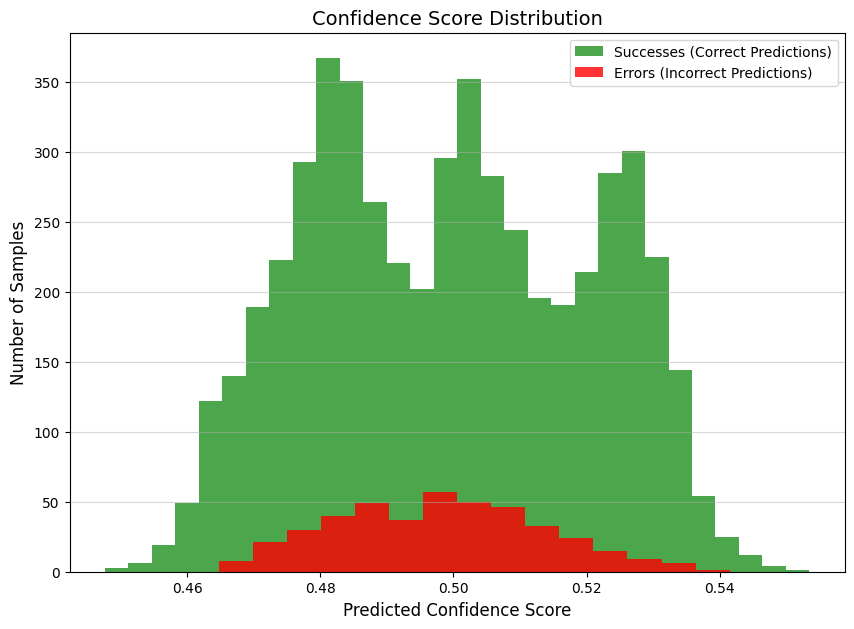

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_labels_int = label_encoder.fit_transform(y_labels)
is_correct = (y_hat == y_true_class)
success_confidences = confidence_scores_lds_fds[is_correct]
error_confidences = confidence_scores_lds_fds[~is_correct]

plt.figure(figsize=(10, 7))
# bins = np.linspace(0, 1, 50)
# plt.hist(success_confidences, bins=bins, alpha=0.7, label='Success', color='green')
# plt.hist(error_confidences, bins=bins, alpha=0.7, label='Error', color='red')

plt.hist(success_confidences, bins=30, alpha=0.7, label='Successes (Correct Predictions)', color='green')
plt.hist(error_confidences, bins=15, alpha=0.8, label='Errors (Incorrect Predictions)', color='red')
plt.xlabel('Predicted Confidence Score', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Confidence Score Distribution', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

